## Set-up

In [2]:
# Install Cornac

!pip install --quiet cornac==1.5.2 adjustText

     |████████████████████████████████| 10.0 MB 15.2 MB/s 


In [3]:
# Set seed

USE_SEED = True

if USE_SEED:
    SEED = 42
else:
    SEED = None

In [4]:
# Install libraries

from datetime import datetime
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cornac
from cornac.eval_methods import RatioSplit
from cornac.hyperopt import Discrete, Continuous
from cornac.hyperopt import GridSearch, RandomSearch
from cornac.metrics import AUC, FMeasure, MAE, MRR, NCRR, NDCG, Precision, Recall, RMSE
from cornac.models import BPR

In [5]:
# Set-up Google Drive

COLAB = True

if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  path =  "/content/drive/MyDrive/mitb/recommender-systems-cs608/project/"
else:
  path = ""

Mounted at /content/drive


In [52]:
def create_submission(model, comment):
  now = datetime.now()
  date_time = now.strftime("%Y-%m-%d-%H-%M-%S")
  # os.mkdir(path+"submissions/"+date_time)
  # os.chdir(path+"submissions/"+date_time)

  with open('submission.txt', 'w') as f:
    # for i in range(10):
    for i in range(len(user_ids_train)):
      next_id = user_ids_train[i]
      next_index = user_ids_train.tolist().index(next_id)
      ranks = model.rank(user_idx=next_index,item_indices=None)[0][:50]
      recs = []
      for j in range(len(ranks)):
        recs.append(item_ids_train[ranks[j]])    
      for k in range(len(recs)):
        f.write(str(recs[k]))
        if k < len(recs)-1:
          f.write(" ")
      if i < len(user_ids_train)-1:
        f.write("\n")
  with open(comment+".txt", 'w') as f:
    f.write("Completed")

  !zip -r 'submission.zip' 'submission.txt'
  return 0

## Load data

In [7]:
# Load training data

train_ratings_seen = pd.read_csv(path + 'train_test_split/train_ratings_seen.csv')
train_ratings_seen_df = pd.DataFrame(train_ratings_seen, columns=["user_id", "item_id", "rating"])
print(train_ratings_seen_df.shape)
train_ratings_seen_df.head()

(119922, 3)


user_id  item_id  rating
0  34297304  1260259     4.0
1  34297304  1137544     3.0
2  34297304  1372673     1.0
3  34297304  2511537     3.0
4  34297304    92537     4.0

In [8]:
# Load test data

test_ratings_unseen = pd.read_csv(path + 'train_test_split/test_ratings_unseen.csv')
test_ratings_unseen_df = pd.DataFrame(test_ratings_unseen, columns=["user_id", "item_id", "rating"])
print(test_ratings_unseen_df.shape)
test_ratings_unseen_df.head()

(22492, 3)


user_id  item_id  rating
0  34297304  1205151     1.0
1  34297304    19481     3.0
2  34297304  1251093     4.0
3  34297304    24169     2.0
4  34297304  1221087     2.0

In [9]:
# Concatenate the data sets
both_df = pd.concat([train_ratings_seen_df, test_ratings_unseen_df], ignore_index=True, axis=0)
print(both_df.shape)
both_df.head()

(142414, 3)


user_id  item_id  rating
0  34297304  1260259     4.0
1  34297304  1137544     3.0
2  34297304  1372673     1.0
3  34297304  2511537     3.0
4  34297304    92537     4.0

In [10]:
# Turn the datasets into tuples

# Train
train_tuples = []
for row in train_ratings_seen_df.itertuples(index=False, name=None):
    train_tuples.append(row)

# Test
probe_tuples = []
for row in test_ratings_unseen_df.itertuples(index=False, name=None):
    probe_tuples.append(row)

# Both
both_tuples = []
for row in both_df.itertuples(index=False, name=None):
    both_tuples.append(row)

In [11]:
# Create Cornac datasets

train_cornac = cornac.data.Dataset.from_uir(train_ratings_seen_df.itertuples(index=False))
test_cornac = cornac.data.Dataset.from_uir(test_ratings_unseen_df.itertuples(index=False))
both_cornac = cornac.data.Dataset.from_uir(both_df.itertuples(index=False))

/usr/local/lib/python3.7/dist-packages/cornac/data/dataset.py:361: UserWarning: 772 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


In [12]:
# Create lists of user ids

user_ids_train = train_ratings_seen_df.user_id.unique()
user_ids_test = test_ratings_unseen_df.user_id.unique()
user_ids_both = both_df.user_id.unique()
print(user_ids_train, len(user_ids_train))
print(user_ids_test, len(user_ids_test))
print(user_ids_both, len(user_ids_both))

[34297304 45453687 49078867 ... 39227239 32474245 58534725] 5066
[34297304 45453687 49078867 ... 39227239 32474245 58534725] 4855
[34297304 45453687 49078867 ... 39227239 32474245 58534725] 5066


In [13]:
# Create lists of user ids

item_ids_train = train_ratings_seen_df.item_id.unique()
item_ids_test = test_ratings_unseen_df.item_id.unique()
item_ids_both = both_df.item_id.unique()
print(item_ids_train, len(item_ids_train))
print(item_ids_test, len(item_ids_test))
print(item_ids_both, len(item_ids_both))

[1260259 1137544 1372673 ... 1910521 1616514 1138829] 39520
[1205151   19481 1251093 ... 1163704    2761 7496969] 9900
[1260259 1137544 1372673 ... 1910521 1616514 1138829] 39520


## Data analysis

### Train dataset

In [14]:
train_ratings_seen_df.rating.describe()

count    119922.000000
mean          3.929759
std           0.681669
min           1.000000
25%           3.500000
50%           4.000000
75%           4.500000
max           5.000000
Name: rating, dtype: float64

In [15]:
100*train_ratings_seen_df.rating.value_counts()/train_ratings_seen_df.rating.count()

4.0    43.685062
3.5    14.995580
4.5    12.963426
5.0    12.956755
3.0    11.788496
2.0     1.440937
2.5     1.410083
1.0     0.560364
1.5     0.199296
Name: rating, dtype: float64

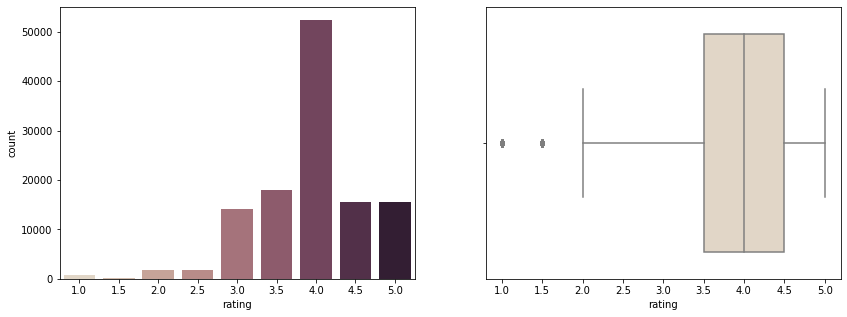

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
sns.countplot(x="rating", data=train_ratings_seen_df, palette="ch:.25", ax=axes[0])
sns.boxplot(x="rating", data=train_ratings_seen_df, palette="ch:.25", ax=axes[1])

In [17]:
print(f"Train data set")
n_users_train = train_ratings_seen_df.user_id.nunique()
n_items_train = train_ratings_seen_df.item_id.nunique()
n_ratings_train = len(train_ratings_seen_df)
rating_matrix_size_train = n_users_train * n_items_train
sparsity_train = 1 - n_ratings_train / rating_matrix_size_train

print(f"Number of users: {n_users_train}")
print(f"Number of items: {n_items_train}")
print(f"Number of available ratings: {n_ratings_train}")
print(f"Number of all possible ratings: {rating_matrix_size_train}")
print(f"Sparsity: {sparsity_train * 100.0:.2f}%")

Train data set
Number of users: 5066
Number of items: 39520
Number of available ratings: 119922
Number of all possible ratings: 200208320
Sparsity: 99.94%


In [18]:
user_rate_count_train = train_ratings_seen_df.groupby("user_id")["item_id"].nunique().sort_values(ascending=False)
user_rate_count_train.head(10)

user_id
26677642    48
21074907    48
6942004     48
40129417    48
34089398    48
6938166     48
20446369    48
52578462    48
20566370    48
39655193    48
Name: item_id, dtype: int64

In [19]:
user_rate_count_train.tail(10)

user_id
54981943    4
52030956    4
55370502    3
29420499    3
40240883    3
36173583    3
55821577    3
53744472    3
56750190    3
26275789    1
Name: item_id, dtype: int64

In [20]:
item_rate_count_train = train_ratings_seen_df.groupby("item_id")["user_id"].nunique().sort_values(ascending=False)
item_rate_count_train.head(10)

item_id
1652       225
1135843    224
7103       181
18978      164
14362      159
75626      153
7972       147
5078       144
75190      143
86684      141
Name: user_id, dtype: int64

In [21]:
item_rate_count_train.tail(10)

item_id
1670136     1
1670099     1
1669968     1
1669712     1
1669337     1
1669050     1
1669038     1
1669002     1
1668966     1
10734831    1
Name: user_id, dtype: int64

### Test dataset

In [22]:
test_ratings_unseen_df.rating.describe()

count    22492.000000
mean         3.949515
std          0.666814
min          1.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          5.000000
Name: rating, dtype: float64

In [23]:
100*test_ratings_unseen_df.rating.value_counts()/test_ratings_unseen_df.rating.count()

4.0    43.944514
3.5    14.849724
4.5    13.889383
5.0    12.951272
3.0    11.083941
2.5     1.396052
2.0     1.231549
1.0     0.489063
1.5     0.164503
Name: rating, dtype: float64

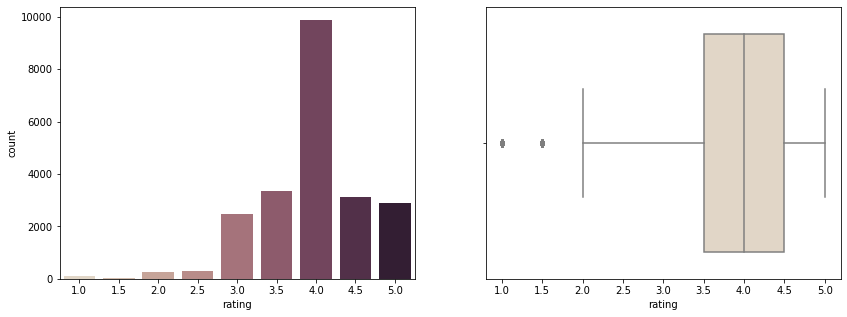

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
sns.countplot(x="rating", data=test_ratings_unseen_df, palette="ch:.25", ax=axes[0])
sns.boxplot(x="rating", data=test_ratings_unseen_df, palette="ch:.25", ax=axes[1])

In [25]:
print(f"Train data set")
n_users_train = test_ratings_unseen_df.user_id.nunique()
n_items_train = test_ratings_unseen_df.item_id.nunique()
n_ratings_train = len(test_ratings_unseen_df)
rating_matrix_size_train = n_users_train * n_items_train
sparsity_train = 1 - n_ratings_train / rating_matrix_size_train

print(f"Number of users: {n_users_train}")
print(f"Number of items: {n_items_train}")
print(f"Number of available ratings: {n_ratings_train}")
print(f"Number of all possible ratings: {rating_matrix_size_train}")
print(f"Sparsity: {sparsity_train * 100.0:.2f}%")

Train data set
Number of users: 4855
Number of items: 9900
Number of available ratings: 22492
Number of all possible ratings: 48064500
Sparsity: 99.95%


In [26]:
user_rate_count_train = test_ratings_unseen_df.groupby("user_id")["item_id"].nunique().sort_values(ascending=False)
user_rate_count_train.head(10)

user_id
5778439     12
26063686    12
25178609    12
43093327    12
41007037    12
49406773    12
44644880    12
11748546    12
762658      12
7565718     12
Name: item_id, dtype: int64

In [27]:
user_rate_count_train.tail(10)

user_id
47363071    1
47175507    1
47339479    1
47319818    1
47308014    1
18880844    1
18955159    1
47233586    1
19415385    1
58534725    1
Name: item_id, dtype: int64

In [28]:
item_rate_count_train = test_ratings_unseen_df.groupby("item_id")["user_id"].nunique().sort_values(ascending=False)
item_rate_count_train.head(10)

item_id
1652       60
1135843    52
7103       50
1163903    39
18978      39
2316699    39
75626      38
14362      37
1125543    36
5078       35
Name: user_id, dtype: int64

In [29]:
item_rate_count_train.tail(10)

item_id
1267661     1
1267578     1
1266103     1
1265164     1
1265045     1
1264703     1
1264146     1
1264139     1
1263924     1
10585726    1
Name: user_id, dtype: int64

### Combined dataset

In [30]:
both_df.rating.describe()

count    142414.000000
mean          3.932879
std           0.679381
min           1.000000
25%           3.500000
50%           4.000000
75%           4.500000
max           5.000000
Name: rating, dtype: float64

In [31]:
100*both_df.rating.value_counts()/both_df.rating.count()

4.0    43.726038
3.5    14.972545
4.5    13.109666
5.0    12.955889
3.0    11.677223
2.0     1.407867
2.5     1.407867
1.0     0.549103
1.5     0.193801
Name: rating, dtype: float64

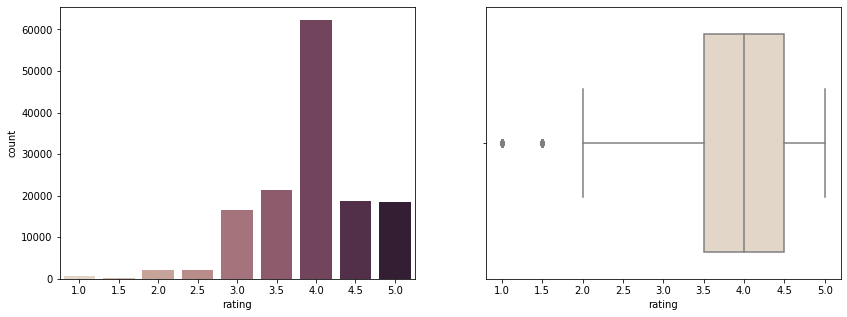

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
sns.countplot(x="rating", data=both_df, palette="ch:.25", ax=axes[0])
sns.boxplot(x="rating", data=both_df, palette="ch:.25", ax=axes[1])

In [33]:
print(f"Train data set")
n_users_train = both_df.user_id.nunique()
n_items_train = both_df.item_id.nunique()
n_ratings_train = len(both_df)
rating_matrix_size_train = n_users_train * n_items_train
sparsity_train = 1 - n_ratings_train / rating_matrix_size_train

print(f"Number of users: {n_users_train}")
print(f"Number of items: {n_items_train}")
print(f"Number of available ratings: {n_ratings_train}")
print(f"Number of all possible ratings: {rating_matrix_size_train}")
print(f"Sparsity: {sparsity_train * 100.0:.2f}%")

Train data set
Number of users: 5066
Number of items: 39520
Number of available ratings: 142414
Number of all possible ratings: 200208320
Sparsity: 99.93%


In [34]:
user_rate_count_train = both_df.groupby("user_id")["item_id"].nunique().sort_values(ascending=False)
user_rate_count_train.head(10)

user_id
47082887    60
25178609    60
49406773    60
7565718     60
47146407    60
43554856    60
11748546    60
32604992    60
43093327    60
5778439     60
Name: item_id, dtype: int64

In [35]:
user_rate_count_train.tail(10)

user_id
53023928    4
36173583    4
28727522    4
56918119    4
7539378     4
29076493    4
56750190    3
55821577    3
53744472    3
26275789    1
Name: item_id, dtype: int64

In [36]:
item_rate_count_train = both_df.groupby("item_id")["user_id"].nunique().sort_values(ascending=False)
item_rate_count_train.head(10)

item_id
1652       280
1135843    273
7103       226
18978      200
14362      192
75626      189
7972       178
5078       172
86684      168
1163903    166
Name: user_id, dtype: int64

In [37]:
item_rate_count_train.tail(10)

item_id
1745590     1
1745279     1
1744813     1
1744544     1
1744315     1
1744201     1
1744153     1
1744046     1
1743770     1
10734831    1
Name: user_id, dtype: int64

## Cornac

### Set-up

In [38]:
VERBOSE = True

In [39]:
data=train_tuples
rs = RatioSplit(data, test_size=0.1, val_size=0.1, seed=SEED, verbose=VERBOSE)

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 5066
Number of items = 34404
Number of ratings = 95936
Max rating = 5.0
Min rating = 1.0
Global mean = 3.9
---
Test data:
Number of users = 3710
Number of items = 5451
Number of ratings = 9303
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 3713
Number of items = 5472
Number of ratings = 9286
---
Total users = 5066
Total items = 34404


In [40]:
# Define the metrics to evaluate the models:

metrics = [
  cornac.metrics.RMSE(),
  cornac.metrics.FMeasure(k=20),
  cornac.metrics.AUC(),
  cornac.metrics.MRR(),
  cornac.metrics.NCRR(k=20),
  cornac.metrics.NDCG(k=20),
  cornac.metrics.Recall(k=20)
]

In [41]:
# Define the base model

bpr=cornac.models.bpr.recom_bpr.BPR(
  k=50, #The dimension of the latent factors.
  max_iter=100, # Maximum number of iterations or the number of epochs for SGD.
  learning_rate=0.001, # The learning rate for SGD.
  lambda_reg=0.001, # The regularization hyper-parameter.
  num_threads=0, # Number of parallel threads for training. If num_threads=0, all CPU cores will be utilized. If seed is not None, num_threads=1 to remove randomness from parallelization.
  trainable=True, # When False, the model will not be re-trained, and input of pre-trained parameters are required.
  verbose=True, # When True, some running logs are displayed.
  init_params=None, # Initial parameters, e.g., init_params = {‘U’: user_factors, ‘V’: item_factors, ‘Bi’: item_biases}.
  seed=SEED, # Random seed for weight initialization. If specified, training will take longer because of single-thread (no parallelization)
)

### Grid Search

In [47]:
# GridSearch

gs_bpr = cornac.hyperopt.GridSearch(
  model=bpr,
  space=[
         Discrete("k", [10, 20, 30, 40, 50, 75, 100]),
         Discrete("max_iter", [50, 100, 200, 400]),
         Discrete("learning_rate", [0.001, 0.002, 0.005, 0.010]),
         Discrete("lambda_reg", [0.001, 0.002, 0.005, 0.010]),
  ],
  metric=cornac.metrics.Recall(k=20),
  eval_method=rs,
)

cornac.Experiment(
  eval_method=rs,
  models=[gs_bpr],
  metrics=metrics,
  user_based=True,
  save_dir='cornac_experiments',
).run()


[GridSearch_BPR] Training started!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 75, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.002, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.005, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.001, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.002, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.005, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 100, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 400}


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!
Best parameter settings: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 200}
Recall@20 = 0.0337

[GridSearch_BPR] Evaluation started!


Rating:   0%|          | 0/9303 [00:00<?, ?it/s]

Ranking:   0%|          | 0/3710 [00:00<?, ?it/s]

Rating:   0%|          | 0/9286 [00:00<?, ?it/s]

Ranking:   0%|          | 0/3713 [00:00<?, ?it/s]

GridSearch_BPR model is saved to cornac_experiments/GridSearch_BPR/2022-06-13_12-29-49-487886.pkl

VALIDATION:
...
               |   RMSE |    AUC |  F1@20 |    MRR | NCRR@20 | NDCG@20 | Recall@20 | Time (s)
-------------- + ------ + ------ + ------ + ------ + ------- + ------- + --------- + --------
GridSearch_BPR | 2.4152 | 0.8298 | 0.0070 | 0.0210 |  0.0102 |  0.0162 |    0.0337 |  22.8774

TEST:
...
               |   RMSE |    AUC |  F1@20 |    MRR | NCRR@20 | NDCG@20 | Recall@20 | Train (s) | Test (s)
-------------- + ------ + ------ + ------ + ------ + ------- + ------- + --------- + --------- + --------
GridSearch_BPR | 2.4077 | 0.8372 | 0.0068 | 0.0206 |  0.0091 |  0.0148 |    0.0313 | 9653.7103 |  22.8802



### Random Search

In [52]:
# RandomSearch

# Best parameter settings: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 200}

rs_bpr = cornac.hyperopt.RandomSearch(
  model=bpr,
  space=[
         Discrete("k", [35, 40, 45]),
         Discrete("max_iter", [150, 200, 250]),
         Continuous("learning_rate", low=0.005, high=0.02),
         Continuous("lambda_reg", low=0.005, high=0.02),
  ],
  metric=cornac.metrics.RMSE(),
  eval_method=rs,
  n_trails=100,
)

cornac.Experiment(
  eval_method=rs,
  models=[rs_bpr],
  metrics=metrics,
  user_based=True,
  save_dir='cornac_experiments',
).run()


[RandomSearch_BPR] Training started!
Evaluating: {'k': 45, 'lambda_reg': 0.016948144802903492, 'learning_rate': 0.007751521847992457, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.007340279606636548, 'learning_rate': 0.00733991780504304, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.01799264218662403, 'learning_rate': 0.014016725176148132, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005846173685406504, 'learning_rate': 0.01582998158400237, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005011681487615215, 'learning_rate': 0.019883173389368264, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.012871346474483566, 'learning_rate': 0.011479175279631736, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.01417779342083569, 'learning_rate': 0.007092407909780628, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.006359096517992312, 'learning_rate': 0.01427579013999631, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.005696756190799966, 'learning_rate': 0.014113172778521574, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.005975773894779193, 'learning_rate': 0.0192332830588, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.010781247538098742, 'learning_rate': 0.005239493783303213, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.015248952782381874, 'learning_rate': 0.014149949866739314, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.01863980603118173, 'learning_rate': 0.008881699724000254, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.012801020317667163, 'learning_rate': 0.013200654190149194, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.01954376941646838, 'learning_rate': 0.016626992350416717, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.018422410256414733, 'learning_rate': 0.013968499682166277, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.007939742936287178, 'learning_rate': 0.005678409333658071, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.00907023547660844, 'learning_rate': 0.01743106263727894, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.009214017645310713, 'learning_rate': 0.013140441247373728, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.017032954711310593, 'learning_rate': 0.006118259655196563, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.01658367153944986, 'learning_rate': 0.007980735223012587, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.007982636061332078, 'learning_rate': 0.01567012929122975, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.014089399621715171, 'learning_rate': 0.018894513177700235, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.018724395133156713, 'learning_rate': 0.01775057866684699, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.005953375254290355, 'learning_rate': 0.009664734825734933, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.013869466815615905, 'learning_rate': 0.009120826894850963, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.010743903121306847, 'learning_rate': 0.019575681430836555, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.0158259428174731, 'learning_rate': 0.008539773796234336, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.00560650384307647, 'learning_rate': 0.015659943345286812, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.011590047527986551, 'learning_rate': 0.008025788035030942, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.0097153397161449, 'learning_rate': 0.01262856036747054, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.008739383437233125, 'learning_rate': 0.011155743845534445, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.008431972482374338, 'learning_rate': 0.006154698647431895, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.007418319308810066, 'learning_rate': 0.018945464785138595, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.014501056347656353, 'learning_rate': 0.018071908852815764, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.013090133628734759, 'learning_rate': 0.017111602327460937, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.01860242662318631, 'learning_rate': 0.00908198374076953, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005007805654929738, 'learning_rate': 0.010288532845012535, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.007469837797144126, 'learning_rate': 0.013011341290631629, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.015386540493354056, 'learning_rate': 0.009041185006977821, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.00984804398031133, 'learning_rate': 0.012781859326150492, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.0059733837066347235, 'learning_rate': 0.00880873120901517, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.01245872758838578, 'learning_rate': 0.009513174647251545, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.009001715214129274, 'learning_rate': 0.019649224337489793, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.009179696963549172, 'learning_rate': 0.018623988289499804, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.007173423081368346, 'learning_rate': 0.012341791404163445, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.015082033211088176, 'learning_rate': 0.016424294229930764, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.015923245229177894, 'learning_rate': 0.010516746990788799, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.010982366636668295, 'learning_rate': 0.01724647809829076, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.009811700974576038, 'learning_rate': 0.007797777655997814, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.013863394147823626, 'learning_rate': 0.015163465427634235, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.012681395874489215, 'learning_rate': 0.00839743662796907, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.015364066071536987, 'learning_rate': 0.010801030194508062, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.015135351755589211, 'learning_rate': 0.01602824178861158, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.013121719607413488, 'learning_rate': 0.01543676599017623, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.019732525149941532, 'learning_rate': 0.012749538369065214, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.019943805496368865, 'learning_rate': 0.019481290269331906, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.018239545147840094, 'learning_rate': 0.007830606625120692, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.015505367449591568, 'learning_rate': 0.017699917133574588, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.014630474692314314, 'learning_rate': 0.0062620994749257326, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.0051379557742494445, 'learning_rate': 0.006522073142990482, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.00507592375769328, 'learning_rate': 0.0074121207712624804, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.0153784279653904, 'learning_rate': 0.014779418892539007, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.005271130454232813, 'learning_rate': 0.01240840572775152, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.014864193384505151, 'learning_rate': 0.013524629050032076, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.014544989272788432, 'learning_rate': 0.008756927279083762, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.019683392874125134, 'learning_rate': 0.012301132294391826, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.016922169553124727, 'learning_rate': 0.012539556396577882, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.007928644816970667, 'learning_rate': 0.01583678172892258, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.016528310214594635, 'learning_rate': 0.005654056576316506, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.009193405126951378, 'learning_rate': 0.018252410333993885, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.01892477843881588, 'learning_rate': 0.011422762224759714, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.019454299656338794, 'learning_rate': 0.017795141832010402, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.010776465929028879, 'learning_rate': 0.017767050072752852, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.013352018936875251, 'learning_rate': 0.019042321612411713, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.013550917551340476, 'learning_rate': 0.006457647406561528, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.010379701719442459, 'learning_rate': 0.00881245473604608, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.009838261463579008, 'learning_rate': 0.017730046923870115, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.015633664953651778, 'learning_rate': 0.013292299653618615, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.011296712846694148, 'learning_rate': 0.00884310415391687, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.005077772941609802, 'learning_rate': 0.014418416224229541, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.016936890041541516, 'learning_rate': 0.018350080127263493, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.010633744289599161, 'learning_rate': 0.006409729097613035, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.005539134106951131, 'learning_rate': 0.011983970271986902, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.009298118781924266, 'learning_rate': 0.013862498908535161, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.005560222831238216, 'learning_rate': 0.017339008409894874, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.006905907689778272, 'learning_rate': 0.012833648900822066, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.011858977424205927, 'learning_rate': 0.01763034612517972, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.015492683161507908, 'learning_rate': 0.00707529638626702, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.012744505224517928, 'learning_rate': 0.009844347094118688, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.011502811063711132, 'learning_rate': 0.01616063964498673, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.007765005114970551, 'learning_rate': 0.006213094499257965, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.015327498511480495, 'learning_rate': 0.005872903932626654, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.011635283445966565, 'learning_rate': 0.00859681038736105, 'max_iter': 200}


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.014902960650765969, 'learning_rate': 0.009199008454189143, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.014856669927502501, 'learning_rate': 0.011535093480168367, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.005715741915374732, 'learning_rate': 0.013490558157411143, 'max_iter': 250}


  0%|          | 0/250 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 35, 'lambda_reg': 0.006802469717084633, 'learning_rate': 0.010128195000746024, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 45, 'lambda_reg': 0.005610932034784552, 'learning_rate': 0.01783190876016511, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.016450466345058663, 'learning_rate': 0.01710369465576169, 'max_iter': 150}


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Best parameter settings: {'k': 35, 'lambda_reg': 0.005560222831238216, 'learning_rate': 0.017339008409894874, 'max_iter': 200}
RMSE = 2.4078

[RandomSearch_BPR] Evaluation started!


Rating:   0%|          | 0/9303 [00:00<?, ?it/s]

Ranking:   0%|          | 0/3710 [00:00<?, ?it/s]

Rating:   0%|          | 0/9286 [00:00<?, ?it/s]

Ranking:   0%|          | 0/3713 [00:00<?, ?it/s]

RandomSearch_BPR model is saved to cornac_experiments/RandomSearch_BPR/2022-06-13_13-03-22-852501.pkl

VALIDATION:
...
                 |   RMSE |    AUC |  F1@20 |    MRR | NCRR@20 | NDCG@20 | Recall@20 | Time (s)
---------------- + ------ + ------ + ------ + ------ + ------- + ------- + --------- + --------
RandomSearch_BPR | 2.2888 | 0.8100 | 0.0051 | 0.0156 |  0.0073 |  0.0122 |    0.0262 |  21.3993

TEST:
...
                 |   RMSE |    AUC |  F1@20 |    MRR | NCRR@20 | NDCG@20 | Recall@20 | Train (s) | Test (s)
---------------- + ------ + ------ + ------ + ------ + ------- + ------- + --------- + --------- + --------
RandomSearch_BPR | 2.2797 | 0.8126 | 0.0059 | 0.0166 |  0.0080 |  0.0135 |    0.0295 |  778.7700 |  21.6548



### Best model

In [53]:
# # Fit the model and create recommendations

# Best parameter settings: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.01, 'max_iter': 200}

bpr_best=cornac.models.bpr.recom_bpr.BPR(
  k=40, #The dimension of the latent factors.
  max_iter=200, # Maximum number of iterations or the number of epochs for SGD.
  learning_rate=0.001, # The learning rate for SGD.
  lambda_reg=0.01, # The regularization hyper-parameter.
  num_threads=0, # Number of parallel threads for training. If num_threads=0, all CPU cores will be utilized. If seed is not None, num_threads=1 to remove randomness from parallelization.
  trainable=True, # When False, the model will not be re-trained, and input of pre-trained parameters are required.
  verbose=True, # When True, some running logs are displayed.
  init_params=None, # Initial parameters, e.g., init_params = {‘U’: user_factors, ‘V’: item_factors, ‘Bi’: item_biases}.
  seed=SEED # Random seed for weight initialization. If specified, training will take longer because of single-thread (no parallelization).
)

bpr_best.fit(train_cornac, test_cornac)
create_submission(bpr_best,"bpr_best")

  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!
  adding: submission.txt (deflated 99%)


0